## ウエハサイズを限定せずに機械学習させる

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import csv

import pickle
import copy
import cv2

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

MAKE_DATASET = True

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 50
encord_size = int(max_size / 2)

### データについて

In [4]:
if MAKE_DATASET:
    df=pd.read_pickle("../input/LSWMD.pkl")

    df = df.drop(['waferIndex'], axis = 1)

    def find_dim(x):
        dim0=np.size(x,axis=0)
        dim1=np.size(x,axis=1)
        return dim0,dim1
    df['waferMapDim']=df.waferMap.apply(find_dim)

In [5]:
if MAKE_DATASET:
    df['failureNum']=df.failureType
    df['trainTestNum']=df.trianTestLabel
    mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
    mapping_traintest={'Training':0,'Test':1}
    df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

    tol_wafers = df.shape[0]

    df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
    df_withlabel =df_withlabel.reset_index()
    df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
    df_withpattern = df_withpattern.reset_index()
    df_nonpattern = df[(df['failureNum']==8)]

### データサイズ関係なく処理

- 使えるデータサイズを求める
    - None以外の合計が50個以上のウエハ
    - サイズが100以下
    - 統一サイズを100

In [6]:
if MAKE_DATASET:
    uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
    wdim = uni_waferDim[0]
    failure_list = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none']
    usable_wdim_list = []
    usable_wafer_num = 0
    for i in range(len(wdim)):
        sub_df = df.loc[df['waferMapDim'] == wdim[i]]
        pattern_num = [0] * 9
        for j in range(len(sub_df)):
            if len(sub_df.iloc[j,:]['failureType']) == 0:
                continue
            pattern = sub_df.iloc[j,:]['failureType'][0][0]
            pattern_num[failure_list.index(pattern)] += 1
        if sum(pattern_num) - pattern_num[8] >= 50 and wdim[i][0] <= max_size and wdim[i][1] <= max_size:
            usable_wdim_list.append(wdim[i])
            print(wdim[i], len(sub_df), sum(pattern_num))
            usable_wafer_num += sum(pattern_num)
    print(usable_wafer_num)

(22, 50) 2971 899
(25, 26) 4417 4174
(25, 27) 64083 18781
(26, 26) 30078 14366
(26, 30) 2065 1513
(27, 25) 12655 10682
(29, 26) 13247 11751
(30, 34) 29513 12400
(31, 28) 10788 337
(31, 31) 14569 486
(31, 33) 1687 69
(32, 29) 108687 413
(33, 29) 20276 8125
(33, 32) 454 450
(33, 33) 23886 231
(33, 37) 3923 3729
(34, 31) 8155 1383
(34, 34) 2529 708
(35, 31) 6629 4331
(35, 36) 1724 55
(35, 40) 10676 408
(38, 36) 2621 2127
(38, 38) 8895 2086
(39, 31) 13562 454
(39, 37) 15327 10173
(39, 46) 399 77
(39, 50) 2353 606
(40, 40) 5224 242
(41, 33) 5432 5091
(41, 38) 5062 4152
(41, 40) 2709 2572
(41, 41) 3167 1463
(41, 42) 4639 1506
(41, 45) 2583 2313
(42, 44) 7035 6724
(43, 42) 1620 1267
(43, 44) 4289 2578
(44, 41) 7131 6134
(44, 44) 8601 144
(45, 42) 2730 2648
(45, 43) 5598 1035
(46, 46) 2168 454
(49, 39) 39323 166
(50, 43) 3326 423
149726


In [7]:
def make_unisize_wafer(size, wafer):
    width, height = wafer.shape
    unisize_wafer = np.zeros((size, size))
    width_pad = int((size - width) / 2)
    height_pad = int((size - height) / 2)
    unisize_wafer[width_pad:width_pad + width, height_pad:height_pad + height] = wafer
    return unisize_wafer

In [8]:
if MAKE_DATASET:
    sw = np.ones((usable_wafer_num, max_size, max_size), dtype='int8')
    label = list()
    count = 0
    for usable_wdim in usable_wdim_list:
        sub_df = df.loc[df['waferMapDim'] == usable_wdim]
        sub_wafer = sub_df['waferMap'].values
        print(usable_wdim)
        print(len(sub_df))

        for i in range(len(sub_df)):
            # skip null label
            if len(sub_df.iloc[i,:]['failureType']) == 0:
                continue
            sw[count] = make_unisize_wafer(max_size, sub_df.iloc[i,:]['waferMap'])
            label.append(sub_df.iloc[i,:]['failureType'][0][0])
            count += 1
            if i % 1000 == 0:
                print(" ", i)
    x = sw
    y = np.array(label).reshape((-1,1))

(22, 50)
2971
(25, 26)
4417
  1000
  2000
  3000
  4000
(25, 27)
64083
  34000
  36000
  45000
  47000
  48000
  50000
  51000
  53000
  54000
  55000
  58000
  59000
  60000
  61000
  62000
(26, 26)
30078
  0
  1000
  2000
  3000
  4000
  5000
  6000
  7000
  20000
  22000
  23000
  24000
  25000
  28000
  29000
  30000
(26, 30)
2065
  1000
  2000
(27, 25)
12655
  2000
  4000
  5000
  6000
  7000
  8000
  9000
  10000
  11000
  12000
(29, 26)
13247
  2000
  3000
  4000
  5000
  6000
  7000
  8000
  9000
  10000
  11000
  12000
  13000
(30, 34)
29513
  7000
  16000
  17000
  18000
  19000
  20000
  21000
  22000
  23000
  24000
  25000
  26000
  27000
  28000
  29000
(31, 28)
10788
(31, 31)
14569
(31, 33)
1687
(32, 29)
108687
  20000
(33, 29)
20276
  11000
  15000
  16000
  17000
  18000
  19000
  20000
(33, 32)
454
(33, 33)
23886
(33, 37)
3923
  1000
  2000
  3000
(34, 31)
8155
  7000
  8000
(34, 34)
2529
  0
  2000
(35, 31)
6629
  0
  2000
  3000
  4000
  6000
(35, 36)
1724
(35, 40)


### xとyをファイルに保存

In [9]:
if MAKE_DATASET:
    faulty_case = np.unique(y)
    print('Faulty case list : {}'.format(faulty_case))
if not MAKE_DATASET:
    faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [10]:
if MAKE_DATASET:
    for f in faulty_case :
        print('{} : {}'.format(f, len(y[y==f])))

Center : 3924
Donut : 447
Edge-Loc : 4145
Edge-Ring : 4377
Loc : 2849
Near-full : 139
Random : 677
Scratch : 809
none : 132359


In [11]:
if MAKE_DATASET:
    for i, l in enumerate(faulty_case):
        y[y==l] = int(i)
        print(type(i))
    y = y.astype(np.int8)

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [12]:
from sklearn.externals import joblib

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f,protocol=4)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

if MAKE_DATASET:
#     joblib.dump(x, './data/xmulti.pickle')
    joblib.dump(y, './data/ymulti' + str(max_size) + '.pickle')
    
if not MAKE_DATASET:
#     x = joblib.load('./data/xmulti.pickle')
    y = joblib.load('./data/ymulti' + str(max_size) + '.pickle')

In [13]:
if MAKE_DATASET:
    print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (149726, 50, 50), y shape : (149726, 1)


In [14]:
for i in range(9) :
    print('{} : {}'.format(i, len(y[y==i])))

0 : 3924
1 : 447
2 : 4145
3 : 4377
4 : 2849
5 : 139
6 : 677
7 : 809
8 : 132359


- 最初のデータを可視化してみる．

In [15]:
if MAKE_DATASET:
    x = x.reshape((-1, max_size, max_size, 1))
    x.shape

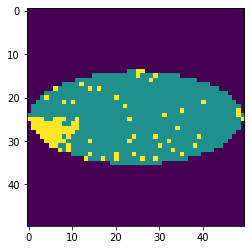

Faulty case : ['Edge-Loc'] 


In [16]:
if MAKE_DATASET:
    # plot 1st data
    plt.imshow(x[0,:, :, 0])
    plt.show()

    # check faulty case
    print('Faulty case : {} '.format(faulty_case[y[0]]))

- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [17]:
# かぶっているものを特定する
count = 0
no = 0
duplicate_list = []
# count = 3142
# no = 14
# duplicate_list = [31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650, 32231, 31834, 32567, 31914, 30976, 31512, 34215, 32261, 31061, 31818, 32146, 31265, 30795, 33187, 30966, 32278, 31115, 34561, 32302, 30961, 31105, 31908, 31400, 34676, 31098, 34751, 33924, 30575, 34168, 31687, 31766, 30821, 32712, 31346, 30986, 31862, 30825, 30744, 32022, 30631, 30647, 31890, 31220, 30667, 33737, 31188, 34989, 31124, 34118, 30823, 30949, 31103, 32771, 33503, 32139, 30843, 31899, 31283, 32191, 30957, 32432, 31327, 31545, 30919, 34552, 30951, 32239, 30612, 33306, 30869, 31601, 31005, 32508, 31786, 34129, 30473, 30624, 30604, 30801, 31491, 32027, 30792, 31010, 31590, 30417, 31578, 30772, 31057, 32693, 34943, 31889, 31017, 30927, 32114, 33763, 30572, 31325, 32226, 32229, 32077, 30938, 34206, 30687, 31091, 31403, 32542, 32020, 31225, 30827, 31438, 30905, 33733, 31320, 30594, 30854, 30817, 30867, 31442, 33971, 30689, 32017, 30672, 30740, 31070, 31929, 30992, 30934, 31740, 32644, 31804, 31667, 32309, 30924, 30601, 31621, 33858, 33423, 32026, 30768, 33675, 34702, 31156, 34656, 31072, 30741, 32272, 31114, 30832, 31928, 34331, 31821, 31706, 30877, 30758, 31832, 30716, 33185, 31678, 31987, 31924, 30857, 30728, 31357, 31193, 31160, 31159, 30937, 34028, 31289, 33492, 32370, 33323, 34481, 31745, 32097, 32695, 30759, 31018, 32537, 30712, 31827, 33916, 30887, 30999, 34262, 30831, 32747, 33168, 30922, 34642, 30988, 30975, 34354, 31677, 34355, 30851, 31546, 31000, 31217, 32250, 31603, 30804, 30732, 30694, 32208, 33671, 30295, 31539, 32101, 30774, 31095, 33229, 31162, 32650, 31364, 32636, 30942, 31015, 34607, 31440, 30436, 33911, 30968, 34433, 32049, 32792, 31474, 31371, 30270, 30969, 31605, 34449, 33445, 30918, 30868, 30649, 30785, 33452, 32336, 31508, 31004, 33018, 30807, 33770, 34027, 30888, 31028, 31093, 30781, 32225, 34255, 34428, 34288, 34640, 30776, 31058, 33756, 31429, 30603, 33448, 30710, 34252, 33267, 32042, 32916, 33851, 33987, 31659, 31261, 31589, 30819, 30841, 31969, 31406, 32679, 32005, 31365, 32564, 30991, 31656, 31064, 33999, 30874, 32794, 34447, 30828, 33175, 31147, 30761, 31759, 31048, 30619, 32206, 31691, 34104, 31660, 33749, 32263, 31652, 33304, 31110, 34391, 30638, 31664, 30926, 31779, 30898, 33494, 30836, 30990, 32021, 34156, 31213, 32416, 31943, 31101, 30678, 31822, 31984, 31135, 31472, 30972, 33315, 30979, 31946, 34435, 32182, 30622, 33328, 33989, 30316, 33722, 30782, 30844, 31047, 30837, 31109, 32193, 33396, 32683, 30916, 31014, 31510, 31909, 32421, 31085, 30293, 32376, 30826, 30708, 31339, 32244, 30933, 34377, 33536, 30640, 30993, 31303, 32288, 32004, 33758, 30598, 32103, 31398, 31722, 32112, 34589, 31567, 31042, 30580, 34623, 35144, 30995, 34604, 31932, 30325, 32096, 30856, 34459, 30848, 30690, 31271, 31055, 31833, 30812, 31003, 34486, 30737, 33838, 31087, 30902, 32752, 33865, 32207, 31306, 33615, 30751, 34645, 31074, 30788, 31502, 31548, 30394, 30901, 30444, 34365, 32612, 30783, 31657, 31090, 34293, 33218, 33028, 31331, 31116, 34488, 30633, 31388, 34358, 32001, 31712, 33535, 34571, 30791, 30811, 31380, 34713, 34330, 30911, 32148, 30959, 30897, 31445, 31499, 31496, 31204, 34122, 31397, 30764, 30824, 32195, 34495, 34290, 33102, 31235, 32071, 34648, 30599, 30766, 30656, 31032, 31056, 33397, 33133, 31088, 31813, 30810, 31489, 30866, 30706, 31795, 34668, 31694, 34271, 32243, 31886, 31871, 30909, 34309, 32661, 33555, 31333, 31865, 32198, 30965, 33928, 31209, 30945, 30723, 31923, 30651, 32446, 30952, 32006, 34152, 31926, 30629, 31963, 30879, 30767, 31770, 34245, 31627, 34059, 32092, 32786, 32842, 30578, 34012, 30762, 31082, 31084, 31075, 30805, 32277, 31127, 31026, 31902, 31065, 30798, 31039, 30729, 32253, 30955, 30839, 31199, 33520, 31268, 30813, 30749, 30890, 32717, 34046, 32108, 34432, 31424, 32267, 30878, 31637, 30691, 30661, 34719, 31092, 31505, 33073, 30946, 31422, 31069, 31513, 30981, 31735, 32637, 31495, 31020, 32228, 32431, 34422, 30562, 30611, 34732, 30707, 31415, 31634, 32032, 30528, 31002, 30755, 31031, 30606, 32219, 30860, 32166, 31568, 31718, 35059, 31100, 31328, 34551, 30646, 30925, 30778, 31556, 34625, 31826, 31977, 32054, 31978, 31956, 31642, 31868, 34634, 34592, 34596, 32142, 34734, 34308, 31130, 31449, 31755, 33245, 31942, 34509, 31176, 34128, 31407, 31727, 34351, 34320, 32240, 31312, 31784, 34425, 31343, 32227, 34580, 34487, 32064, 34269, 31437, 34291, 31430, 33873, 35039, 34445, 31967, 32070, 31588, 31298, 31120, 34213, 31591, 31747, 31234, 34529, 31286, 34660, 32673, 31314, 34160, 33093, 31879, 32186, 31450, 31394, 31368, 31945, 31224, 34562, 31632, 34166, 31744, 34455, 31291, 34535, 31587, 31122, 34728, 31488, 31575, 32028, 31555, 33505, 31396, 32298, 32297, 34243, 32638, 32544, 32145, 34678, 34069, 34597, 31477, 32168, 31952, 31202, 31492, 34512, 34665, 31705, 34197, 32947, 32002, 32241, 32211, 32115, 31302, 34127, 33624, 31730, 31683, 31777, 31348, 31476, 31149, 32073, 33016, 31771, 31142, 31614, 31401, 31873, 34294, 31561, 32266, 31252, 33870, 33215, 31901, 32039, 32119, 34663, 32177, 31251, 33589, 33402, 31266, 31990, 31922, 31405, 32268, 34336, 31342, 31673, 31378, 31460, 33486, 32287, 31840, 31803, 34680, 32045, 34590, 32799, 31915, 31238, 31542, 32348, 31537, 31809, 34181, 32280, 34276, 31782, 31582, 31708, 33264, 31151, 32083, 34616, 32136, 32199, 32135, 31355, 32157, 31577, 31785, 31326, 32078, 33173, 31267, 31917, 33940, 31316, 31604, 32615, 32160, 31898, 34437, 31434, 31685, 34557, 31843, 31408, 31386, 33712, 31506, 31332, 34226, 31576, 31351, 31232, 31481, 31329, 34722, 32210, 31936, 33170, 34742, 32179, 34624, 34224, 31882, 31793, 34147, 34521, 32011, 31170, 31249, 32100, 31383, 31572, 34870, 34531, 33571, 31675, 34721, 31321, 31423, 31530, 34144, 34261, 31812, 32137, 31285, 34514, 32279, 32058, 31970, 31543, 31233, 32117, 33967, 31986, 32559, 32010, 33664, 31214, 34523, 31709, 34615, 32306, 34720, 31906, 31874, 31165, 31367, 31900, 31960, 32270, 32680, 31307, 31466, 31701, 32426, 32014, 31602, 31927, 31410, 31884, 31988, 31792, 34612, 31796, 32299, 34462, 31850, 31798, 31692, 31518, 34356, 33319, 31764, 32291, 31300, 31523, 31171, 34489, 31317, 31780, 34583, 32846, 34522, 31648, 35029, 33437, 31742, 32212, 34670, 34456, 34415, 31425, 34319, 34450, 31145, 34733, 34584, 34170, 31939, 34744, 34370, 31374, 32152, 31448, 31805, 34282, 32172, 33782, 31447, 31150, 34389, 32035, 31949, 31296, 31277, 31431, 31620, 31192, 31765, 34285, 31690, 34568, 34652, 31606, 34434, 31810, 33019, 31174, 31458, 34476, 31702, 34546, 31763, 32470, 34199, 34244, 31966, 31345, 31323, 34161, 32922, 32102, 32149, 31563, 31295, 31517, 31704, 32224, 35147, 34179, 31389, 31725, 33982, 34525, 31341, 34577, 34416, 31816, 31128, 34223, 31934, 31835, 34141, 31574, 32111, 31299, 32251, 34712, 34079, 31399, 31287, 32202, 31206, 31428, 32188, 34510, 34664, 31935, 32110, 32124, 31540, 31728, 31529, 34511, 31562, 34544, 31262, 33575, 31467, 31861, 32041, 32535, 34519, 34234, 31726, 34704, 34553, 31191, 33276, 31753, 31806, 31391, 32003, 34826, 32069, 31565, 34910, 34448, 31881, 31375, 31912, 34383, 32281, 34585, 33836, 31337, 31695, 32164, 34174, 31258, 31799, 34145, 32162, 34198, 31384, 31452, 31855, 31643, 31336, 31129, 31168, 32950, 34430, 34673, 34207, 34726, 31971, 34695, 31707, 32155, 34536, 31749, 32181, 31973, 31304, 31382, 34385, 34142, 34274, 32209, 31177, 32031, 31134, 31352, 32576, 31119, 31596, 34208, 31717, 32061, 32301, 31715, 31456, 31823, 34227, 35088, 34332, 33975, 31494, 34491, 31564, 34162, 32249, 34830, 31859, 32120, 32154, 31349, 32296, 31264, 31500, 31653, 31247, 34669, 31962, 33336, 32175, 31608, 32123, 32183, 31189, 34254, 31270, 31311, 31800, 31525, 32060, 33605, 31190, 31570, 32245, 33935, 31465, 31767, 31844, 32303, 31253, 32654, 33163, 32161, 33879, 35185, 34770, 35334, 35275, 35129, 35249, 35192, 35314, 35208, 35070, 34677, 34229, 35982, 34258, 34839, 35927, 35037, 35151, 35228, 34313, 35211, 34136, 35400, 34967, 35730, 35182, 34542, 34815, 35217, 35106, 34945, 35372, 35267, 35524, 34225, 34990, 35902, 32523, 35549, 33746, 36085, 35330, 34864, 35245, 34899, 34304, 34915, 35038, 35072, 36045, 35352, 34832, 35109, 34396, 34220, 34508, 35080, 35309, 35503, 34931, 34756, 35574, 34853, 35428, 35206, 36214, 34924, 34784, 35117, 35090, 35057, 35896, 35107, 35469, 35311, 36241, 34918, 35537, 34257, 34167, 35221, 36293, 35907, 35140, 35429, 34979, 34984, 35254, 34151, 36062, 35569, 35344, 35071, 34133, 35434, 34256, 35459, 34591, 34961, 34296, 35315, 34922, 35177, 35132, 35085, 36131, 27493, 34004, 35346, 34792, 34818, 34501, 34554, 35815, 35374, 35395, 35563, 35310, 36031, 35447, 36008, 35022, 34667, 34954, 35699, 35231, 34963, 35278, 35099, 35251, 34939, 34936, 35535, 36239, 34626, 34209, 35285, 34942, 36243, 34259, 35055, 34697, 35502, 34851, 35027, 35585, 35210, 36070, 34810, 35098, 34834, 34988, 34892, 34736, 34871, 35156, 35075, 35404, 35332, 34767, 34913, 35464, 35486, 35856, 34840, 35230, 35571, 35095, 34846, 34559, 34962, 36201, 35292, 34374, 35728, 36250, 34420, 35881, 35356, 34240, 35086, 34334, 35915, 35671, 35420, 35337, 34284, 35436, 34787, 35145, 33773, 35442, 35101, 35033, 35538, 34798, 35273, 35399, 35360, 35584, 35553, 34004, 34376, 35383, 35397, 34598, 35243, 35056, 34893, 35069, 35418, 34710, 35264, 34466, 34973, 34494, 34139, 35543, 35350, 36257, 34875, 34502, 33270, 34239, 33418, 36222, 34855, 34187, 35388, 34794, 34407, 35487, 35518, 35475, 35643, 35489, 34927, 35023, 36120, 35094, 34421, 35270, 35561, 35626, 35484, 34898, 35232, 35282, 35509, 35342, 34279, 34964, 35650, 35741, 34352, 34920, 35701, 35807, 34854, 35995, 35583, 34976, 34763, 34632, 34861, 36282, 35817, 35369, 34404, 35242, 35366, 35417, 34946, 35394, 34852, 35754, 34982, 35155, 34748, 35163, 35089, 35296, 34175, 34651, 35153, 36192, 35468, 32936, 35324, 34608, 34969, 34884, 35018, 34793, 35205, 35284, 35565, 35575, 35393, 36058, 35427, 33081, 35354, 34806, 34878, 35299, 35190, 36157, 35119, 35122, 34985, 35432, 35143, 35446, 35641, 34581, 35333, 34752, 34889, 35239, 34776, 34388, 35748, 34423, 35338, 34159, 34843, 35568, 34757, 35523, 35410, 34272, 35250, 35286, 34872, 34386, 35424, 34036, 35218, 35531, 35483, 34357, 35043, 32584, 35148, 35234, 34777, 34171, 34808, 34771, 34766, 35124, 35002, 35079, 35437, 33314, 35924, 36297, 34633, 35603, 35548, 35209, 34452, 35150, 35365, 34923, 34896, 35357, 35000, 34446, 35006, 34150, 35016, 34960, 35530, 34263, 35135, 35474, 36102, 34311, 34786, 32964, 35371, 34219, 35252, 35335, 36218, 35402, 35121, 34869, 35750, 34995, 34911, 34153, 35567, 35376, 35325, 35180, 35083, 32574, 34803, 35277, 35582, 34917, 35064, 35396, 35154, 35587, 35246, 34916, 35258, 34183, 36040, 34774, 34620, 35162, 35268, 35128, 35554, 35115, 35974, 35259, 34929, 34754, 35378, 34980, 35169, 34841, 34600, 35025, 35498, 35712, 35081, 35281, 35463, 35559, 35678, 35274, 35074, 35403, 35351, 35001, 35229, 34788, 35943, 34824, 34454, 35872, 35519, 34796, 35693, 34619, 34231, 35888, 34999, 35516, 34807, 35632, 34605, 35047, 35136, 35226, 34740, 34820, 35131, 34926, 34828, 34402, 34541, 35020, 34809, 34800, 34411, 34965, 35262, 34986, 35564, 35326, 35113, 34729, 32608, 35541, 34865, 35253, 35076, 33265, 35640, 34804, 35062, 36081, 34997, 34444, 35452, 35405, 33885, 35906, 35348, 35340, 35235, 35280, 33131, 33814, 35842, 32668, 35830, 33783, 32685, 32323, 35630, 33855, 32312, 36231, 32621, 32690, 35611, 33785, 36156, 35814, 33518, 33144, 32498, 33540, 35961, 32418, 36162, 32586, 33070, 32325, 32993, 36404, 35855, 33556, 32678, 32478, 36165, 33134, 32981, 32549, 33112, 32526, 32989, 33504, 36204, 33852, 32452, 32600, 35591, 35913, 33123, 35867, 32512, 33044, 33157, 33186, 36233, 33809, 33005, 32350, 33111, 32417, 32401, 32355, 32445, 33808, 35616, 33151, 33757, 36585, 35954, 32647, 32379, 33817, 33417, 33349, 32816, 32740, 32914, 34110, 33403, 34123, 34080, 33616, 32911, 34066, 33234, 33261, 33691, 34057, 32954, 32883, 36057, 33727, 36041, 33438, 35684, 33983, 35651, 32852, 34089, 33651, 32837, 33677, 35717, 33289, 34047, 33628, 36087, 33230, 34049, 33407, 35681, 33337, 36105, 33981, 33972, 33369, 33976, 33622, 32724, 34071, 33454, 33639, 36083, 32956, 34111, 33225, 33248, 32966, 36027, 33947, 33271, 35747, 32791, 33676, 36038, 33421, 33726, 35745, 35660, 36272, 33685, 34090, 35679, 36072, 32743, 36338, 32875, 32871, 32987, 33128, 33811, 33596, 32341, 32587, 32984, 33892, 32607, 32618, 33502, 33860, 33115, 32424, 33539, 32536, 35843, 33803, 32651, 32630, 32461, 32631, 35972, 32663, 33074, 32319, 33549, 32457, 35893, 33182, 33029, 36147, 35923, 33512, 36167, 32487, 36150, 32371, 32657, 32346, 33841, 33834, 33058, 36224, 32971, 32598, 33542, 35910, 33864, 32617, 35863, 33071, 36207, 32455, 33881, 36184, 32502, 33795, 36240, 32474, 33199, 36188, 33523, 35839, 32525, 35898, 32398, 32991, 36173, 33585, 32518, 32592, 35920, 35882, 35963, 33002, 35975, 32494, 32580, 36263, 33914, 35685, 33704, 32811, 33920, 32715, 33406, 35665, 34063, 33931, 32758, 33308, 33455, 34007, 35713, 33287, 32802, 33330, 34086, 36304, 36326, 35797, 33327, 33378, 33699, 32915, 36246, 32801, 33929, 33672, 35721, 33439, 35664, 33663, 33434, 35661, 32942, 32880, 36251, 34005, 33246, 35794, 33623, 36317, 35722, 36273, 36012, 32831, 33231, 33739, 33978, 32775, 34019, 33361, 35696, 33300, 32912, 36002, 33370, 32902, 33631, 36019, 35769, 33687, 33324, 34102, 33927, 33442, 36001, 33627, 32735, 32963, 33310, 36021, 33260, 32937, 34317, 33939, 33673, 32823, 36274, 36319, 36098, 35788, 33365, 32859, 32945, 32932, 34001, 33283, 34022, 33960, 33344, 33992, 32825, 35725, 32754, 33904, 32818, 32814, 34105, 33390, 36097, 33366, 33440, 33665, 32958, 36028, 33309, 36252, 33355, 33288, 36084, 32787, 33686, 35792, 33321, 33392, 32733, 36249, 32941, 33273, 34348, 33730, 34072, 36033, 34091, 36118, 36324, 33667, 36346, 33371, 32890, 33295, 36294, 33302, 32721, 35802, 36265, 33425, 36266, 34109, 36025, 32886, 32800, 33748, 32946, 32925, 33432, 33889, 33867, 32484, 33079, 32499, 33604, 33195, 35873, 36142, 33828, 33527, 33790, 33868, 33506, 32411, 35819, 35877, 35608, 32595, 36172, 36186, 32628, 33041, 32475, 33038, 32462, 33500, 32682, 35634, 33205, 32322, 33191, 32413, 32339, 36138, 32642, 36171, 33884, 32565, 32485, 36225, 32990, 32666, 32358, 33551, 35623, 32497, 32599, 32611, 33048, 32506, 33887, 33212, 33189, 33780, 32317, 32500, 32363, 36199, 33509, 33765, 32469, 32634, 36146, 32352, 35900, 33080, 32999, 33587, 35947, 35859, 32629, 33522, 32510, 32539, 32440, 35883, 33110, 35909, 32328, 32476, 32543, 35617, 33548, 35857, 32633, 33591, 35598, 32589, 35937, 32434, 35619, 32373, 32554, 32399, 33530, 33890, 33053, 32985, 32627, 33113, 32640, 33024, 36219, 32447, 33888, 33581, 33097, 33835, 32547, 32581, 33200, 32513, 32550, 32675, 33177, 32327, 32353, 33534, 36220, 36176, 33148, 36195, 32570, 32318, 32422, 32529, 36407, 33525, 36215, 32969, 35592, 35945, 32585, 33035, 32504, 33614, 32345, 33583, 33543, 32423, 35820, 33857, 35911, 32622, 33498, 32383, 33166, 32532, 33171, 35824, 35804, 36163, 33037, 33558, 36180, 33197, 33203, 36159, 35948, 33114, 33087, 33154, 33759, 32403, 35600, 36130, 35631, 33821, 33771, 35633, 33010, 32572, 32430, 36208, 36217, 33066, 33839, 33570, 35823, 35864, 32326, 33078, 32531, 32660, 35933, 32333, 33767, 33090, 36206, 36166, 32588, 33569, 33559, 36209, 32357, 33120, 33055, 35812, 35624, 32410, 33006, 33846, 32645, 33840, 33150, 35837, 33180, 35834, 33047, 32635, 32451, 33847, 33077, 32603, 33050, 32320, 32594, 33127, 35604, 33593, 32606, 35757, 32821, 36255, 32734, 32718, 36091, 33638, 34097, 32888, 35782, 33383, 33986, 36050, 36262, 34015, 35672, 33274, 33249, 33646, 34055, 33740, 33895, 32869, 33305, 33670, 32751, 32874, 33280, 33278, 34067, 34038, 32726, 33385, 33656, 33907, 36095, 35708, 35645, 33683, 34021, 36065, 33741, 34029, 32967, 33926, 33647, 32959, 33480, 33474, 36020, 33679, 35767, 34052, 33908, 35682, 33303, 33678, 32949, 33994, 33312, 34082, 36056, 32780, 32853, 36022, 32826, 32836, 33702, 32938, 32813, 33451, 36114, 35686, 34092, 35638, 36000, 36305, 35731, 33470, 35998, 33217, 34101, 32841, 36044, 35703, 36258, 36017, 34125, 33427, 33703, 33993, 33299, 33660, 33266, 33320, 36327, 33404, 35655, 36023, 33290, 33412, 33220, 34106, 36332, 32924, 33379, 35666, 33680, 36080, 34088, 32885, 36270, 33922, 33952, 35691, 33226, 34081, 36075, 35800, 33734, 32860, 32843, 33405, 32917, 32897, 32803, 32806, 33743, 33461, 32769, 33444, 34051, 32783, 33692, 33296, 32929, 33973, 32757, 34065, 33941, 34043, 33621, 33716, 36312, 32933, 36061, 33277, 33431, 36076, 34062, 36079, 36049, 33275, 33705, 35720, 33360, 32817, 33729, 36288, 33294, 34034, 35785, 32851, 33747, 35795, 35674, 35770, 36269, 32940, 36291, 33915, 36051, 32896, 36275, 33429, 32889, 32838, 32828, 33965, 33472, 35649, 32778, 34020, 33255, 33674, 33353, 32884, 32965, 32893, 32772, 32731, 33459, 36090, 33980, 33649, 32745, 33331, 36013, 33700, 33285, 35729, 32727, 33316, 33996, 36003, 34008, 33222, 34024, 32763, 36313, 35784, 33719, 35711, 34093, 33465, 33934, 36024, 36344, 33242, 33235, 33415, 35793, 36182, 33084, 32390, 32507, 33804, 35862, 32501, 35605, 32382, 36200, 32503, 32463, 32688, 36175, 33789, 32692, 32702, 32409, 33820, 36161, 32597, 33196, 35984, 32517, 35953, 36213, 36154, 35871, 33495, 33565, 32579, 32665, 35821, 35610, 35929, 33597, 32709, 33015, 32344, 33190, 33049, 32573, 35925, 33577, 33052, 33797, 33130, 32700, 32442, 35952, 33869, 35865, 32973, 33769, 32605, 32324, 32575, 33850, 33878, 33524, 32699, 33844, 36236, 32601, 33051, 32538, 33139, 35845, 33046, 32444, 35726, 33893, 32849, 34874, 32873, 34812, 33001, 34730, 35139, 36141, 33252, 35689, 33633, 33819, 33119, 36352, 35734, 35827, 32519, 33174, 35964, 33598, 35811, 35944, 32464, 33468, 35801, 36341, 33228, 33103, 33744, 33507, 33923, 35648, 34497, 36627, 34579, 33906, 35138, 34635, 36052, 36569, 33902, 36412, 32716, 33082, 32648, 32505, 36006, 36483, 36466, 32919, 32511, 33798, 34287, 36632, 36441, 36500, 33254, 34671, 34325, 35732, 36242, 35796, 34699, 35983, 36556, 34098, 33897, 36621, 35996, 36572, 33825, 33784, 33251, 34211, 36384, 32623, 34825, 33608, 32711, 36636, 33377, 33332, 33968, 35658, 34708, 36112, 33845, 32934, 33568, 33030, 36228, 36640, 34500, 36453, 33209, 36248, 34477, 36424, 32882, 35901, 36153, 36545, 36360, 36037, 35833, 33959, 32974, 33061, 34876, 34302, 36405, 34599, 36427, 36612, 34200, 33476, 36198, 32927, 33603, 32314, 32812, 32602, 34298, 36026, 35791, 36101, 33065, 32773, 33650, 34138, 33990, 32713, 35149, 33409, 34246, 33183, 32419, 36482, 36260, 35749, 35962, 33957, 35111, 33493, 34545, 33067, 34233, 34441, 35904, 34115, 33833, 34791, 34790, 33519, 36361, 34379, 36576, 32687, 36440, 36426, 33165, 36550, 33560, 35978, 34189, 32384, 36559, 32996, 34112, 36504, 36618, 36492, 35108, 36615, 34273, 34848, 32365, 36135, 33874, 34621, 34689, 35965, 35908, 33802, 36060, 34347, 33526, 36582, 32311, 32649, 34037, 33411, 36374, 35779, 33876, 33449, 36584, 33257, 36386, 32918, 36557, 33094, 36583, 34329, 33240, 36589, 33750, 34164, 36389, 35097, 34601, 34180, 36145, 36591, 33453, 36454, 35798, 34614, 36110, 36391, 36506, 36339, 32369, 36430, 33479, 36638, 33866, 36586, 34934, 33760, 36460, 32681, 32694, 34116, 36487, 33233, 33398, 32335, 34362, 33736, 32878, 36578, 36388, 33192, 36560, 34429, 36497, 35786, 36365, 33659, 34762, 35931, 35716, 36457, 36539, 33313, 32710, 34154, 35919, 32979, 32930, 32496, 36548, 36565, 35621, 32578, 35991, 35787, 33954, 36606, 32827, 36472, 35008, 36310, 36169, 34214, 36625, 36535, 35847, 32785, 36385, 34267, 36449, 35977, 36377, 36474, 33219, 32483, 36372, 33478, 33436, 34940, 36292, 33813, 35705, 34564, 36519, 34649, 35809, 36447, 33854, 36359, 36414, 33625, 36347, 36422, 32994, 36370, 36152, 33036, 32385, 32840, 35894, 34974, 33963, 35967, 34717, 32944, 33514, 33501, 32867, 32725, 33872, 35876, 33146, 34236, 36410, 35120, 35675, 35985, 32562, 32391, 35958, 36626, 36588, 36534, 35905, 33946, 35331, 32807, 33368, 34527, 34586, 34555, 35765, 36467, 34464, 34039, 36602, 33032, 33333, 32857, 33069, 33450, 34095, 35702, 36549, 36348, 36007, 36611, 34253, 35806, 34387, 36529, 36517, 36350, 36502, 33012, 35639, 36495, 36380, 32894, 32920, 32609, 36390, 32552, 34417, 35895, 35103, 32340, 36137, 36289, 33356, 36463, 35718, 33720, 34335, 34638, 33298, 36553, 36396, 34850, 35112, 32952, 32766, 36516, 35879, 33550, 36381, 36069, 35003, 35934, 36433, 32541, 34822, 36371, 35992, 34126, 33485, 33776, 36446, 36394, 36437, 36630, 36555, 35450, 36496, 36579, 35288, 35818, 36552, 36607, 35302, 35799, 35949, 35772, 35576, 35586, 36525, 36452, 35521, 36570, 36074, 35482, 35773, 36622, 35220, 35440, 35593, 36299, 35297, 35529, 35581, 36205, 35431, 36613, 35415, 36358, 36066, 35364, 36531, 35466, 36397, 36493, 36653, 36616, 36479, 36402, 35578, 36564, 35323, 36261, 35312, 36471, 35522, 35480, 35540, 36416, 35766, 36561, 36134, 35570, 35298, 35956, 35496, 35557, 35460, 36547, 36104, 35752, 36373, 35422, 35912, 36600, 36514, 35456, 36528, 35308, 35386, 36309, 36603, 35244, 36450, 36542, 35490, 36524, 36133, 36015, 35551, 36608, 36366, 36191, 35444, 35216, 36628, 35255, 35233, 35513, 36078, 35411, 36587, 35928, 35295, 36617, 35572, 36475, 36642, 36566, 35289, 36488, 36563, 43439, 46285, 46274, 46222, 46200, 46207, 46240, 46284, 46249, 46283, 46253, 46242, 46217, 46269, 46251, 46356, 46343, 46355, 46365, 46354, 46366, 46332, 46344, 46289, 46314, 46308, 46316, 46317, 46287, 46126, 46109, 46085, 46104, 46113, 46089, 46153, 46158, 46184, 46151, 46163, 46138, 46386, 46383, 46410, 46399, 46371, 46413, 46408, 46368, 46401, 46404, 46412, 46033, 46059, 46026, 46031, 46058, 46054]
for i in range(0, 86000):#x.shape[0]):
    if i % 500 == 0:
        print(i)
        print(count)
        print(no)
        print(duplicate_list)
    dup = 0
    for j in range(i+1, x.shape[0]):
        if x[i, encord_size, encord_size] != x[j, encord_size, encord_size]:
            continue
        if np.array_equal(x[i], x[j]):
            count += 1
            dup += 1
            if y[i][0] != y[j][0]:  
                no += 1
                print(str(i) + ":" + str(y[i][0]) + ", " + str(j) + ":" + str(y[j][0]))
#                 plt.imshow(x[i])
#                 plt.show()
            else:
                duplicate_list.append(j)
    if dup > 1:
        print(f"dup: {i}")

print(count)
print(no)
print(duplicate_list)

0
0
0
[]
500
0
0
[]
1000
0
0
[]
1500
0
0
[]
2000
0
0
[]
2500
0
0
[]
3000
0
0
[]
3500
0
0
[]
4000
0
0
[]
4500
0
0
[]
5000
0
0
[]
5500
0
0
[]
6000
0
0
[]
6500
0
0
[]
7000
0
0
[]
7500
0
0
[]
8000
0
0
[]
8500
0
0
[]
9000
0
0
[]
9500
0
0
[]
10000
0
0
[]
10500
0
0
[]
11000
0
0
[]
11500
0
0
[]
12000
0
0
[]
12500
0
0
[]
13000
0
0
[]
13500
0
0
[]
14000
0
0
[]
14500
0
0
[]
15000
0
0
[]
15500
0
0
[]
16000
0
0
[]
16500
0
0
[]
17000
0
0
[]
17500
0
0
[]
18000
0
0
[]
18500
0
0
[]
19000
0
0
[]
19500
0
0
[]
20000
0
0
[]
20500
0
0
[]
21000
0
0
[]
21500
0
0
[]
22000
0
0
[]
22500
0
0
[]
23000
0
0
[]
23500
0
0
[]
24000
76
0
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 321

25833:8, 34745:2
25957:0, 34496:8
26000
966
4
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 3

27000
1287
5
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650,

27118:8, 34857:2
dup: 27210
27500
1443
6
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611,

27566:8, 35307:2
28000
1576
7
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 315

28482:8, 34882:0
28500
1736
8
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 315

28875:2, 33282:8
29000
2145
9
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 315

29014:0, 33576:4
29375:8, 32877:4
29500
2560
11
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274,

29682:3, 34813:2
29912:3, 33007:2
30000
3040
13
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274,

30092:8, 35215:2
30500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31

31000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

31500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

32000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

32500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

33000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

33500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

34000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

34500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

35000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

35500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

36000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

36500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

37000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

37500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

38000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

38500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

39000
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

39500
3160
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

40000
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

40500
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

41000
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

41500
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

42000
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

42500
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

43000
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

43500
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

44000
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

44500
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

45000
3161
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

45500
3176
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

46000
3217
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

46500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

47000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

47500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

48000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

48500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

49000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

49500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

50000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

50500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

51000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

51500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

52000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

52500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

53000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

53500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

54000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

54500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

55000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

55500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

56000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

56500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

57000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

57500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

58000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

58500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

59000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

59500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

60000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

60500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

61000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

61500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

62000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

62500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

63000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

63500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

64000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

64500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

65000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

65500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

66000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

66500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

67000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

67500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

68000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

68500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

69000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

69500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

70000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

70500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

71000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

71500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

72000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

72500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

73000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

73500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

74000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

74500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

75000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

75500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

76000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

76500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

77000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

77500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

78000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

78500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

79000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

79500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

80000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

80500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

81000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

81500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

82000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

82500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

83000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

83500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

84000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

84500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

85000
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

85500
3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650

3218
14
[31089, 32105, 30806, 30906, 30745, 32233, 31125, 31111, 30977, 31852, 31076, 31260, 31610, 30971, 31016, 31516, 30886, 34837, 30608, 33272, 30818, 30416, 31918, 30914, 31227, 32076, 31651, 30676, 30541, 30621, 30845, 34228, 31470, 34907, 30790, 31099, 35100, 30769, 30591, 31533, 30893, 30645, 31402, 33618, 34158, 30873, 32024, 32143, 31216, 31381, 31569, 31067, 34506, 34516, 30858, 32196, 32223, 31418, 31372, 34743, 32593, 34042, 32018, 31330, 31522, 31680, 31693, 30944, 30634, 30727, 32741, 31013, 30884, 33136, 31444, 30983, 31955, 31628, 31830, 31282, 34761, 32094, 32197, 30852, 32085, 31269, 31219, 30970, 32084, 30579, 31931, 30794, 32088, 31600, 32361, 30652, 30584, 31097, 32283, 31802, 32903, 30829, 33143, 30842, 31123, 31607, 34177, 32830, 31528, 33711, 33062, 31035, 31979, 30771, 31141, 32765, 31549, 30964, 30738, 31279, 31875, 31776, 32257, 31025, 32190, 31483, 32255, 32260, 34148, 31024, 31079, 30996, 30982, 32977, 33017, 31274, 31611, 30797, 31579, 30859, 30650, 3223

In [35]:
duplicate_list

[149352, 149477, 149628, 149687]

In [17]:
if MAKE_DATASET:
    new_x = np.zeros((len(x), max_size, max_size, 3), dtype='int8')

    for w in range(len(x)):
        for i in range(max_size):
            for j in range(max_size):
                new_x[w, i, j, int(x[w, i, j])] = 1
        print(w)

In [18]:
if MAKE_DATASET:
    joblib.dump(new_x, './data/new_xmulti_' + str(max_size) + '.pickle')
    
if not MAKE_DATASET:
    new_x = joblib.load('./data/new_xmulti_' + str(max_size) + '.pickle')

In [19]:
# # cupyに変換
# print(type(new_x))
# print(type(y))
# new_x = np.asarray(new_x)
# y = np.asarray(y)
# print(type(new_x))
# print(type(y))

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．

### かぶりの除去

In [20]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|       272|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|             MAKE_DATASET|        24|
|                      Out|       248|
|                     copy|        88|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                 datapath|        59|
|                   device|        80|
|                  dirname|        57|
|              encord_size|        28|
|                     exit|        64|
|              faulty_case|       144|
|                 filename|        58|
|                filenames|       104|
|              get_ipython|        72|
|                        i|        28|
|                    image|        88|
|                   joblib|        88|
|                     joi

### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [21]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Encoder
    input_shape = (max_size, max_size, 3)
    input_tensor = Input(input_shape)
    encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

    latent_vector = layers.MaxPool2D()(encode)

    # Decoder
    decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
    decode_layer_2 = layers.UpSampling2D()
    output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

    # connect decoder layers
    decode = decode_layer_1(latent_vector)
    decode = decode_layer_2(decode)

    ae = models.Model(input_tensor, output_tensor(decode))
    ae.compile(optimizer = 'Adam',
                  loss = 'mse',
                 )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [22]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 50, 50, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 100, 100, 3)       1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [23]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [24]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
153/153 [==============================] - 21s 138ms/step - loss: 0.0140
Epoch 2/30
153/153 [==============================] - 20s 132ms/step - loss: 0.0033
Epoch 3/30
153/153 [==============================] - 20s 132ms/step - loss:

- エンコーダだけのモデルを定義する．

In [25]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [26]:
decoder_input = Input((encord_size, encord_size, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [27]:
# Encode original faulty wafer
# encoded_x = np.zeros((156581, 50, 50, 64), dtype="int8")
# encoded_x = (encoder.predict(new_x))
# encoded_x0 = convert_float_to_01(encoder.predict(new_x[0].reshape(1, 100, 100, 3)))
# print(new_x[0].dtype)
# print(encoded_x0.dtype)
# print(new_x[0].shape)
# print(encoded_x0.shape)
# print(new_x[0])
# print(encoded_x0)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [28]:
# Add noise to encoded latent faulty wafers vector.
# noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 50, 50, 64))

- 元のウエハ画像

In [29]:
# check original faulty wafer data
# plt.imshow(np.argmax(new_x[3], axis=2))

- ノイズが付加されたウエハ画像

In [30]:
# # check new noised faulty wafer data
# noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
# plt.imshow(noised_gen_x[3])

In [31]:
# 01に変換する
def convert_float_to_01(wafer):
    width, height, c = wafer.shape
    int_wafer = np.zeros((width, height, c), dtype='int8')
    for i in range(width):
        for j in range(height):
            max_index = np.argmax(wafer[i, j])
            for k in range(3):
                int_wafer[i, j, k] = 1 if k == max_index else 0
    return int_wafer

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．

In [32]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, max_size, max_size, 3), dtype='int8')
    int_noised_gen_x = np.zeros_like(wafer, dtype='int8')
    
    # Make wafer until total # of wafer to 2000
    for i in range((10000//len(encoded_x)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), encord_size, encord_size, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        for wafer_num in range(noised_gen_x.shape[0]):
            int_noised_gen_x[wafer_num] = convert_float_to_01(noised_gen_x[wafer_num])
        gen_x = np.concatenate((gen_x, int_noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    print(label, gen_x.shape)
    
    del encoded_x
    del noised_encoded_x
    del noised_gen_x
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [33]:
none_idx = np.where(y==8)[0][np.random.choice(len(np.where(y==8)[0]), size=117000, replace=False)]
new_x = np.delete(new_x, none_idx, axis=0)
y = np.delete(y, none_idx, axis=0)

In [34]:
y.shape

(39581, 1)

In [35]:
# Augmentation for all faulty case.
for i in range(9) : 
    # skip none case
    if i == 8 : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==i)[0]], i)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))
    del gen_x
    del gen_y

0 (12076, 100, 100, 3)
1 (10429, 100, 100, 3)
2 (13537, 100, 100, 3)
3 (17639, 100, 100, 3)
4 (12001, 100, 100, 3)
5 (10009, 100, 100, 3)
6 (10641, 100, 100, 3)
7 (10099, 100, 100, 3)


In [36]:
new_x.size

4080120000

In [37]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (136004, 100, 100, 3), new_y shape : (136004, 1)


In [38]:
for i in range(9) :
    print('{} : {}'.format(i, len(y[y==i])))

0 : 16100
1 : 10902
2 : 18048
3 : 26457
4 : 15000
5 : 10147
6 : 11400
7 : 11016
8 : 16934


In [39]:
new_y = y

- データオーギュメンテーションを行った結果，各不良データごとに2000枚増えた．
- 合計は30707枚となった．

- 不良ラベルのないデータは削除し，枚数を不良ラベルと同程度にする．

In [40]:
# none_idx = np.where(y==8)[0][np.random.choice(len(np.where(y==8)[0]), size=120000, replace=False)]

In [41]:
# new_x = np.delete(new_x, none_idx, axis=0)
# new_y = np.delete(y, none_idx, axis=0)

In [42]:
# print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

In [43]:
# for i in range(9) :
#     print('{} : {}'.format(i, len(new_y[new_y==i])))

- 削除した結果，全体は19707枚となった．

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

In [44]:
# new_y = y

In [45]:
# for i, l in enumerate(faulty_case):
#     new_y[new_y==l] = i

In [46]:
# one-hot-encoding
new_y = to_categorical(new_y)

- 学習データ（学習データと学習時のテストデータ）と最終的なテストデータに分割する．

In [47]:
# new_X=new_x[0:19000]
# new_Y=new_y[0:19000]
# test_x=new_x[19001:19706]
# test_y=new_y[19001:19706]
# test_x.shape
new_X = new_x
new_Y = new_y

- 学習データを学習データと学習時のテストデータに分割する．

In [48]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.1,
                                                    random_state=2019)

In [49]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (122403, 100, 100, 3), y : (122403, 9)
Test x: (13601, 100, 100, 3), y : (13601, 9)


- 学習データ12730枚，テストデータ6270枚．

- モデルの定義を行う．

In [50]:
def create_model():
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(256, activation='relu')(flat)
        dense_2 = layers.Dense(64, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [51]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
#results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
#print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.10%であった．

- Cross validationなしで学習する．

In [52]:
# del new_x
# del new_X

In [55]:
epoch=30
batch_size=2048
model = create_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [56]:
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
60/60 [==============================] - 38s 636ms/step - accuracy: 0.5935 - loss: 1.6482 - val_accuracy: 0.8198 - val_loss: 0.5184
Epoch 2/30
60/60 [==============================] - 36s 600ms/step - accuracy: 0.8620 - loss: 0.3911 - val_accuracy: 0.9020 - val_loss: 0.2809
Epoch 3/30
60/60 [==============================] - 35s 583ms/step - accuracy: 0.9356 - loss: 0.1967 - val_accuracy: 0.9442 - val_loss: 0.1640
Epoch 4/30
60/60 [==============================] - 37s 620ms/step - accuracy: 0.9679 - loss: 0.1085 - val_accuracy: 0.9731 - val_loss: 0.0940
Epoch 5/30
60/60 [==============================] - 36s 608ms/step - accuracy: 0.9858 - loss: 0.0561 - val_accuracy: 0.9868 - val_loss: 0.0507
Epoch 6/30
60/60 [==============================] - 37s 620ms/step - accuracy: 0.9837 -

- テストデータで評価．    

In [57]:
score = model.evaluate(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score[1])

426/426 [==============================] - 3s 7ms/step - accuracy: 0.9954 - loss: 0.0183
Testing Accuracy: 0.9954414963722229


- acuurayは99.31%であった．

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [58]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 640000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               163840256 
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1644

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

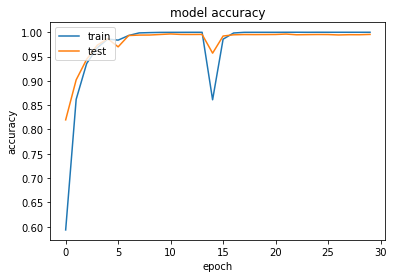

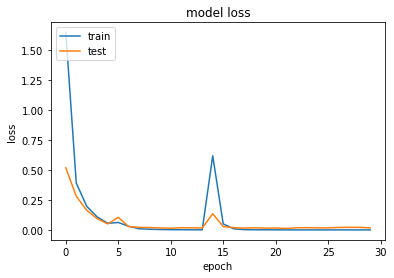

In [59]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()